# Outliers, Leverage, and Influential Observations

*What makes an observation "unusual"?*

In data science, one common task is outlier detection. This is a broad term that is often misused or misunderstood. More broadly, we are often interested in understanding any observation is **"unusual"**. First of all, what does it mean to be unusual? In this article we are going to inspect three different ways in which an observation can be unusual: it can be unusual characteristics, it might not fit the model or it might be particularly influential in fitting the model. We will see that in linear regression the latter characteristics is a byproduct of the first two.

Importantly, being unusual is **not necessarily bad**. Observations that have different characteristics from all others usually carry more information. We also expect some observations not to fit the model well, otherwise the model is likely biased (overfitting). However, "unusual" observations are also more likely to be generated by a different process. Extreme cases include measurement error or fraud, but differences can be more nuanced. Domain knowledge is always kind and dropping observations only for for statistical reasons is never wise.

That said, let's have a look at some different ways in which observations can be "unusual".

# Example

Suppose we are an **peer-to-peer online platform** and we are interested in understanding if there is anything suspicious going on with our business. We have information about how much time our customers spend on the platform and the total value of their transactions.

First, let's have a look at the data. I import the data generating process `dgp_p2p()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py). I include code snippets from [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. For our purpose, Deepnote is very handy because it allows me not only to include code but also output, like data and tables.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
from src.utils import *
from src.dgp import dgp_p2p

In [18]:
df = dgp_p2p().generate_data()
df.head()

,hours,transactions
0,2.6,8.30
1,2.0,8.00
2,7.0,21.00
3,6.7,18.00
4,1.2,3.82


We have information on 50 clients for which we observe `hours` spent on the website and total `transactions` amount. Since we only have two variables we can easily inspect them using a scatterplot.

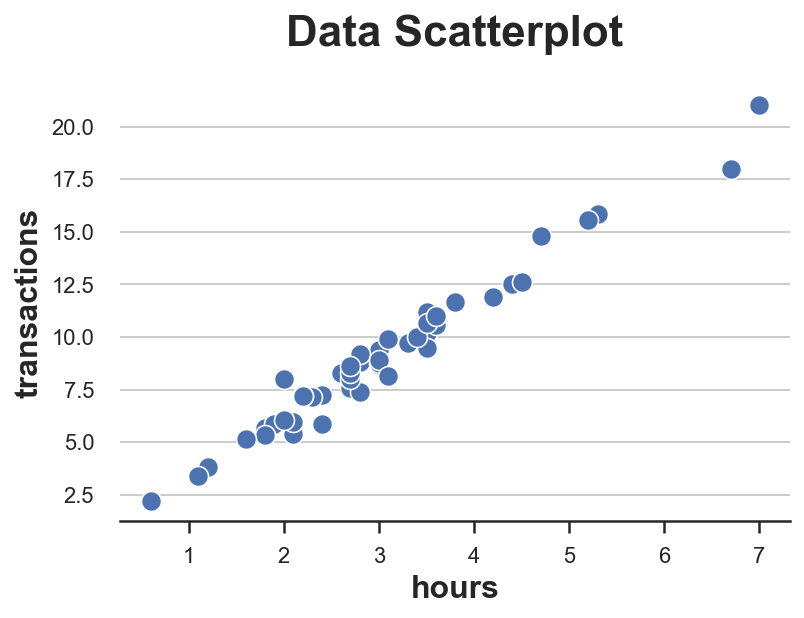

In [19]:
sns.scatterplot(data=df, x='hours', y='transactions').set(title='Data Scatterplot');

The relationship between `hours` and `transactions` seems to follow a clear linear relationship. If we fit a linear model, we observe a particularly tight fit.

In [20]:
smf.ols('hours ~ transactions', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0975,0.084,-1.157,0.253,-0.267,0.072
transactions,0.3452,0.009,39.660,0.000,0.328,0.363


Does any data point look suspiciously different from the others? How?

## Leverage

The first metric that we are going to use to evaluate "unusual" observations is the **leverage**, which was first introduced by [Cook (1980)](https://www.jstor.org/stable/1268249). The objective of the leverage is to capture how much a single point is different with respect to other data points. These data points are often called **outliers** and there exist a nearly amount of algorithms and rules of thumb to flag them.However the idea is the same: flagging observations that are unusual in terms of features.

The leverage of an observation $i$ is defined as

$$
h_{ii} := x_i' (X'X)^{-1} x_i
$$

One interpretation of the leverage is as a **measure of distance** where individual observations are compared against the average of all observations. 

Another interpretation of the leverage is as the influence of the outcome of observation $i$, $y_i$, on the corresponding fitted value $\hat{y_i}$.

$$
h_{ii} = \frac{\partial \hat{y}_i}{\partial y_i}
$$

Algebraically, the leverage of observation $i$ is the $i^{th}$ element of the **design matrix** $X' (X'X)^{-1} X$. Among the many properties of the leverages, is the fact that they are non-negative and their values sum to 1.

Let's compute the leverage of the observations in our dataset. We also flag observations that have unusual leverages (which we arbitrarily define as more than two standard deviations away from the average leverage).

In [21]:
X = np.reshape(df['hours'].values, (-1, 1))
Y = np.reshape(df['transactions'].values, (-1, 1))

In [22]:
df['leverage'] = np.diagonal(X @ np.linalg.inv(X.T @ X) @ X.T)
df['high_leverage'] = df['leverage'] > (np.mean(df['leverage']) + 2*np.std(df['leverage']))

Let's plot the distribution of leverage values in our data.

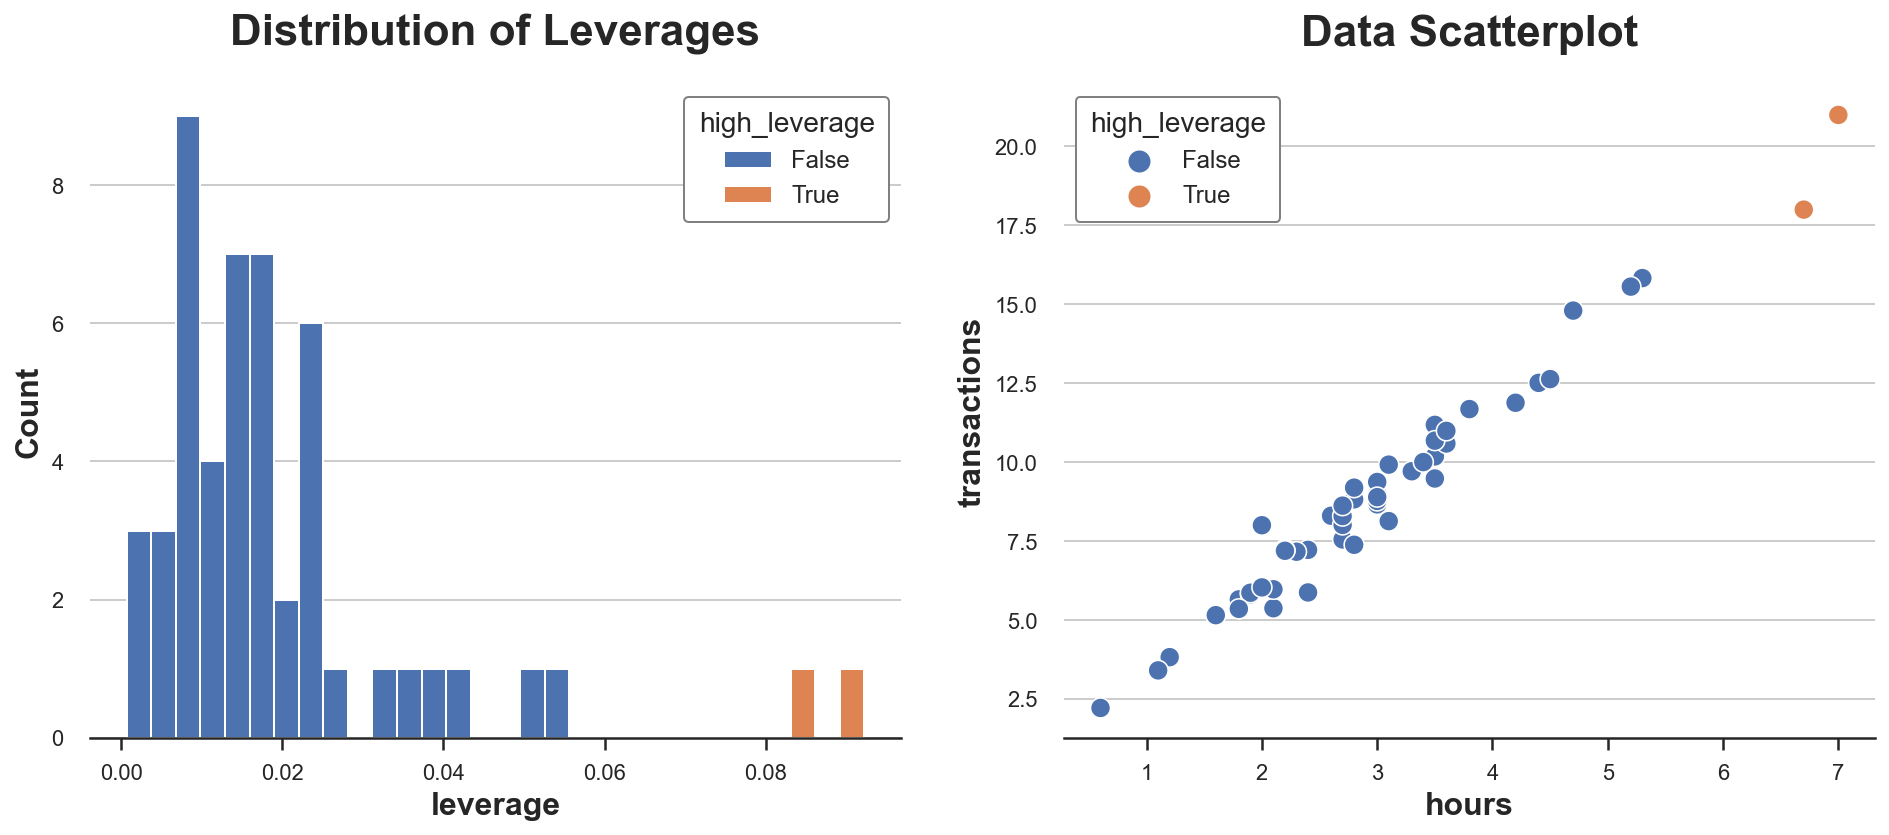

In [23]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=df, x='leverage', hue='high_leverage', alpha=1, bins=30, ax=ax1).set(title='Distribution of Leverages');
sns.scatterplot(data=df, x='hours', y='transactions', hue='high_leverage', ax=ax2).set(title='Data Scatterplot');

As we can see, the distribution is skewed with two observations having a unusually high leverage. Indeed, in the scatterplot these two observations are slightly separated from the rest of the distribution.

Is this bad news? It depends. Outliers are **not a problem per se**. Actually, if they are genuine observations, they might carry much more information than other observations. On the other hand, they are also more likely *not* to be genuine observations (e.g. fraud, measurement error, ...) or to be inherently different from the other ones (e.g. professional users vs amateurs). In any case, we might want to investigate further and use as much context-specific information as we can.

Importantly, the fact that an observation has a high leverage tells us information about the features of the model but nothing about the model itself. Are these users just different observations or they also behave differently?

## Residuals

So far we have only talked about unusual features, but what about **unusual behavior**? This is what regression residuals measure.

Regression residuals are the difference between the predicted outcome values and the observed outcome values. In a sense, they capture what the model cannot explain: the higher the residual of one observation the more it is unusual in the sense that the model cannot explain it. 

In the case of linear regression, residuals can be written as

$$
\hat{e} = y - \hat{y} = y - \hat \beta X
$$

In our case, since $X$ is one dimensional (`hours`), we can easily visualize them.

In [24]:
Y_hat = X @ np.linalg.inv(X.T @ X) @ X.T @ Y

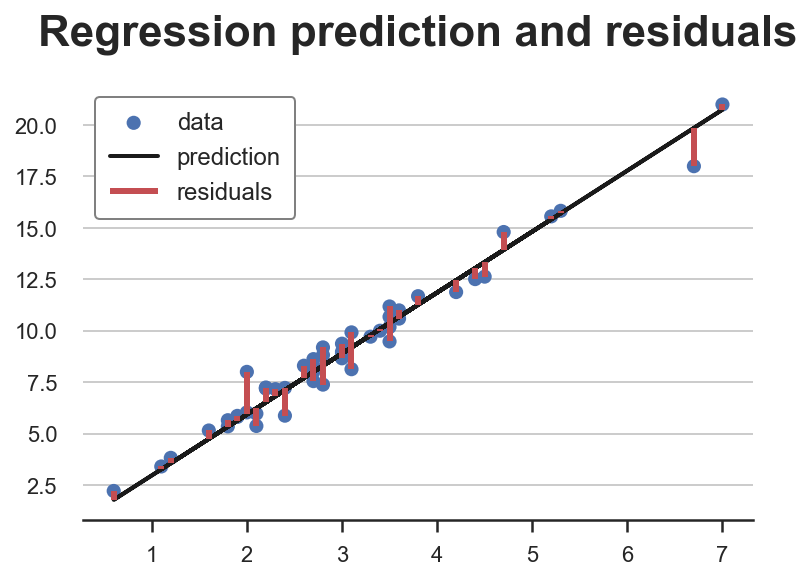

In [25]:
plt.scatter(X, Y, s=50, label='data')
plt.plot(X, Y_hat, c='k', lw=2, label='prediction')
plt.vlines(X, np.minimum(Y, Y_hat), np.maximum(Y, Y_hat), color='r', lw=3, label="residuals");
plt.legend()
plt.title(f"Regression prediction and residuals");

Do some observations have unusually high residuals? Let's plot their distribution.

In [26]:
df['residual'] = np.abs(Y - X @ np.linalg.inv(X.T @ X) @ X.T @ Y)
df['high_residual'] = df['residual'] > (np.mean(df['residual']) + 2*np.std(df['residual']))

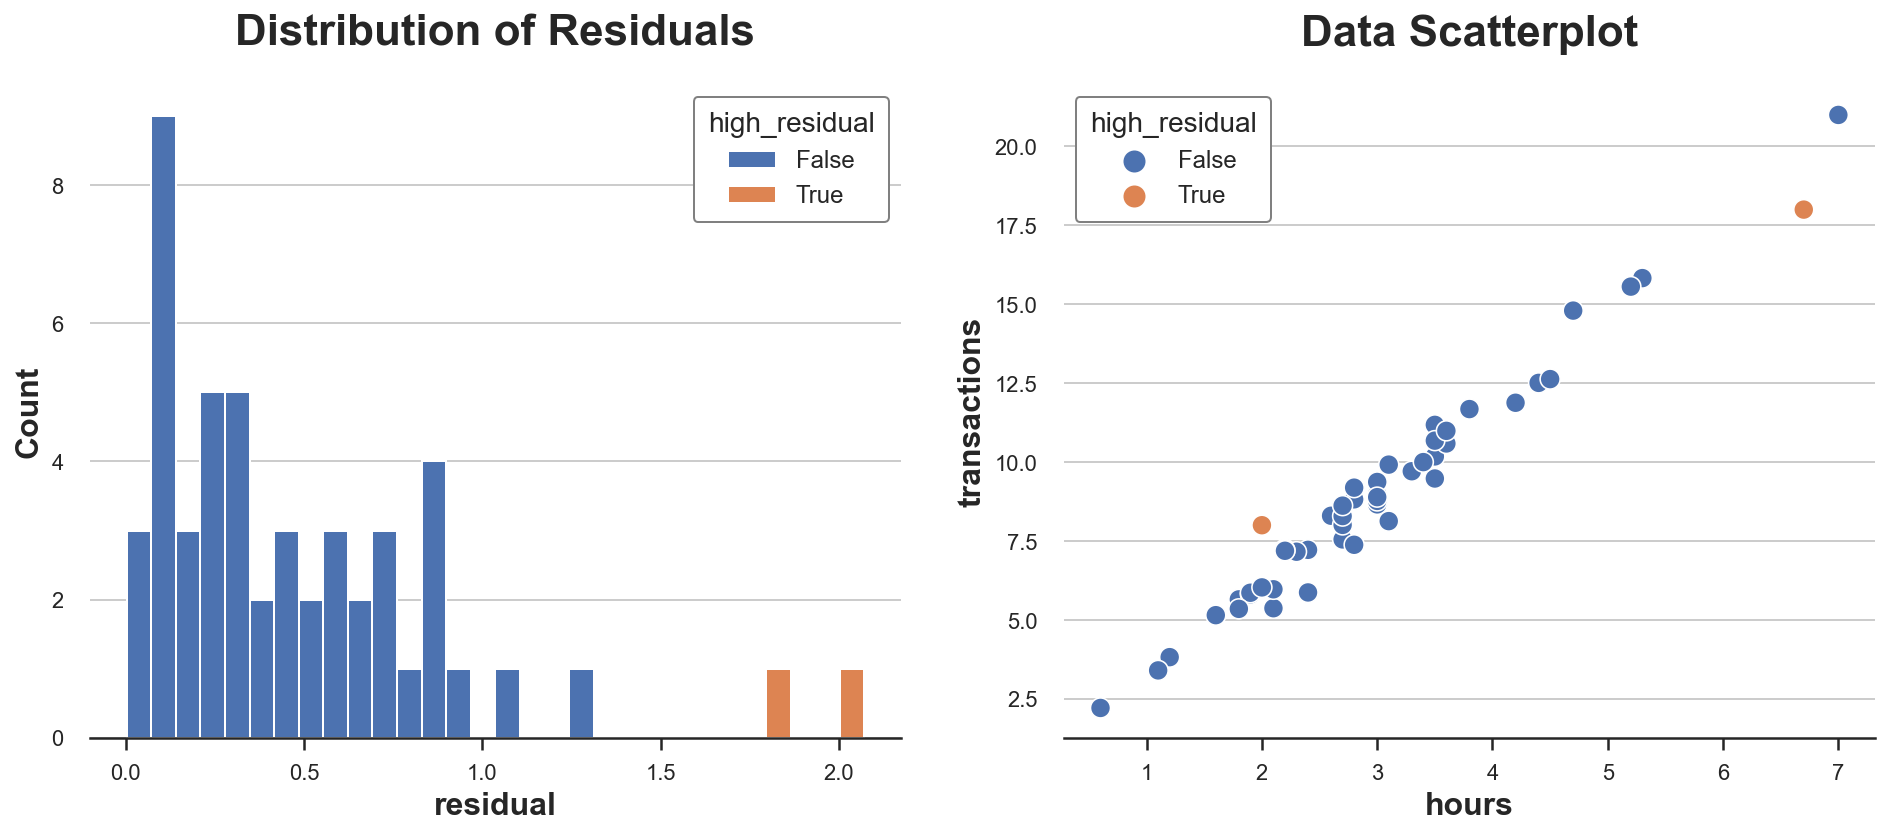

In [27]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=df, x='residual', hue='high_residual', alpha=1, bins=30, ax=ax1).set(title='Distribution of Residuals');
sns.scatterplot(data=df, x='hours', y='transactions', hue='high_residual', ax=ax2).set(title='Data Scatterplot');

Two observations have particularly high residuals. This means that for these observations, the model is not good at predicting the observed outcomes.

Is this bad news? Not necessarily. A model that fits the observations too well is likely to be [**biased**](https://en.wikipedia.org/wiki/Bias_(statistics)). However, it might still be important to understand why some users have a different relationship between hours spent and total transactions. As usual, information on the specific context is key.

So far we have looked at observations with "unusual" characteristics and "unusual" model fit, but what is the observation itself is distorting the model? How much our model is driven by a handful of observations?

## Influence

The concept of **influence and influence functions** was developed precisely to answer this question: what are influential observations? This questions were very popular in the 80's and lost appeal for a long time until the recent need of explaining complex machine learning and AI models. 

The general idea is to define an observation as **influential** if removing it significantly changes the estimated model. In linear regression, we define the influence of observation $i$ as:

$$
\hat{\beta} - \hat{\beta}_{-i} = (X'X)^{-1} x_i e_i
$$

Where $\hat{\beta}_{-i}$ is the OLS coefficient estimated omitting observation $i$.

As you can see, there is a tight connection to both leverage $h_{ii}$ and residuals $e_i$: influence is almost the product of the two. Indeed, in linear regression, observations with high leverage are observations that are both outliers and have high residuals. None of the two conditions alone is sufficient for an observation to have an influence on the model. 

We can see it best in the data.

In [28]:
df['influence'] = (np.linalg.inv(X.T @ X) @ X.T).T * np.abs(Y - Y_hat)
df['high_influence'] = df['influence'] > (np.mean(df['influence']) + 2*np.std(df['influence']))

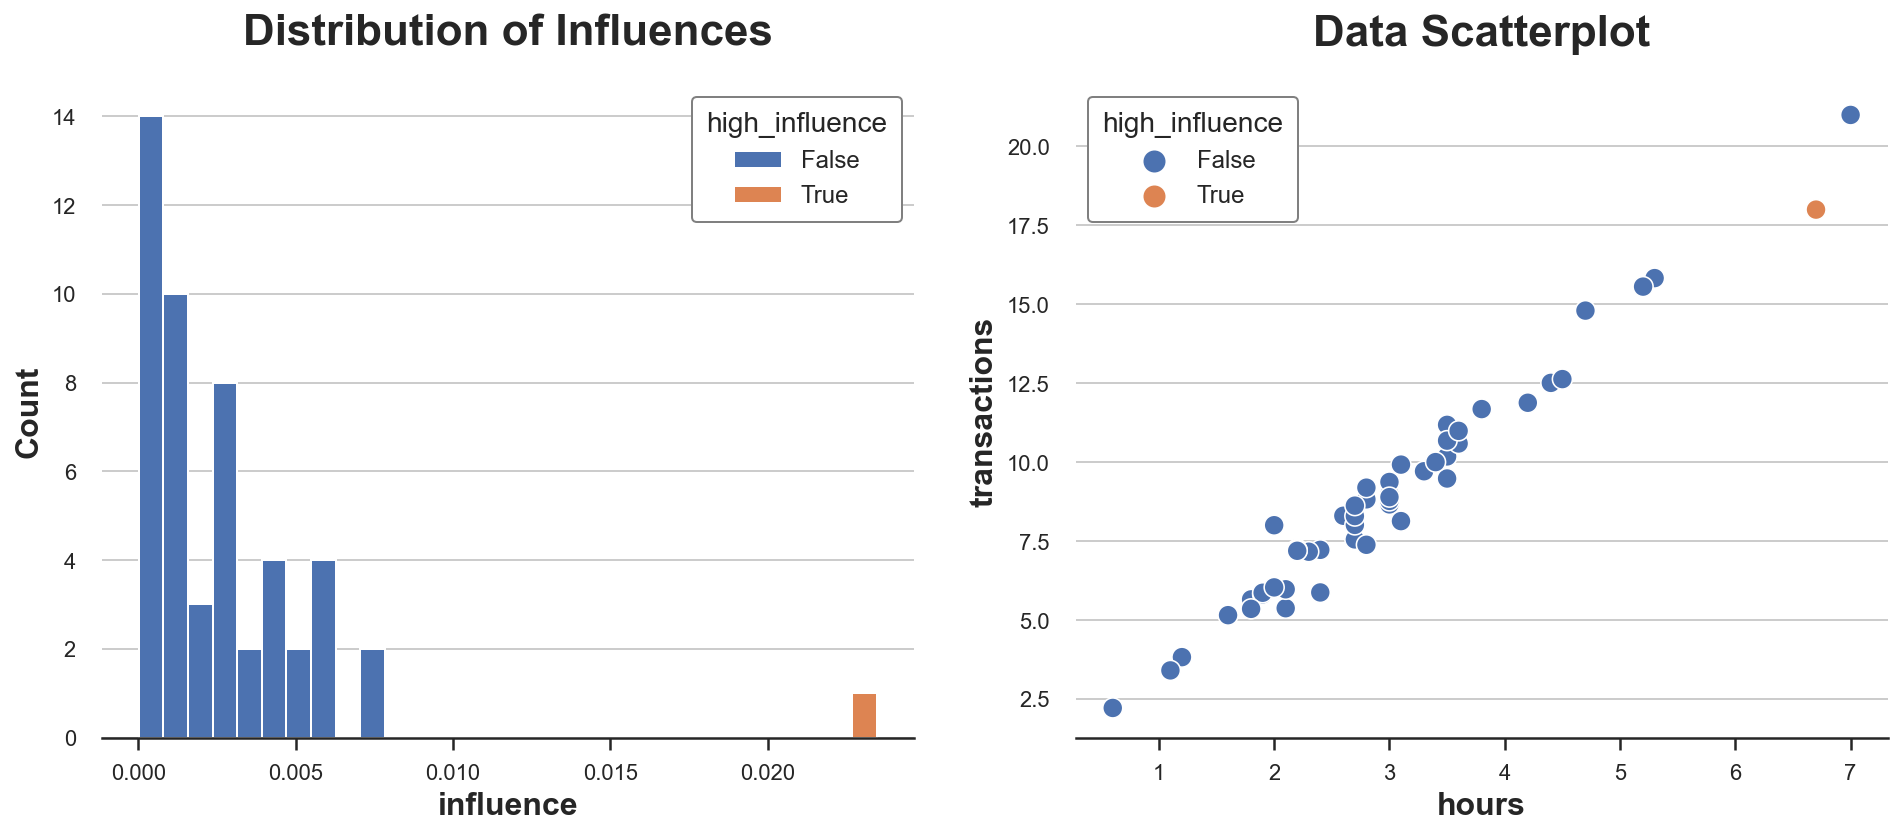

In [29]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=df, x='influence', hue='high_influence', alpha=1, bins=30, ax=ax1).set(title='Distribution of Influences');
sns.scatterplot(data=df, x='hours', y='transactions', hue='high_influence', ax=ax2).set(title='Data Scatterplot');

In our dataset, there is only one observation with high influence, and it is disproportionally larger than the influence of all other observations. 

We can now plot all "unusual" points in the same plot. I also report residuals and leverage of each point in a separate plot.

In [49]:
def plot_leverage_residuals(df):

    # Hue
    df['type'] = 'Normal'
    df.loc[df['high_residual'], 'type'] = 'High Residual'
    df.loc[df['high_leverage'], 'type'] = 'High Leverage'
    df.loc[df['high_influence'], 'type'] = 'High Influence'

    # Init figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
    ax1.plot(X, Y_hat, lw=1, c='grey', zorder=0.5)
    sns.scatterplot(data=df, x='hours', y='transactions', ax=ax1, hue='type').set(title='Data')
    sns.scatterplot(data=df, x='residual', y='leverage', hue='type', ax=ax2).set(title='Metrics')
    ax1.get_legend().remove()
    sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.05, 0.8));

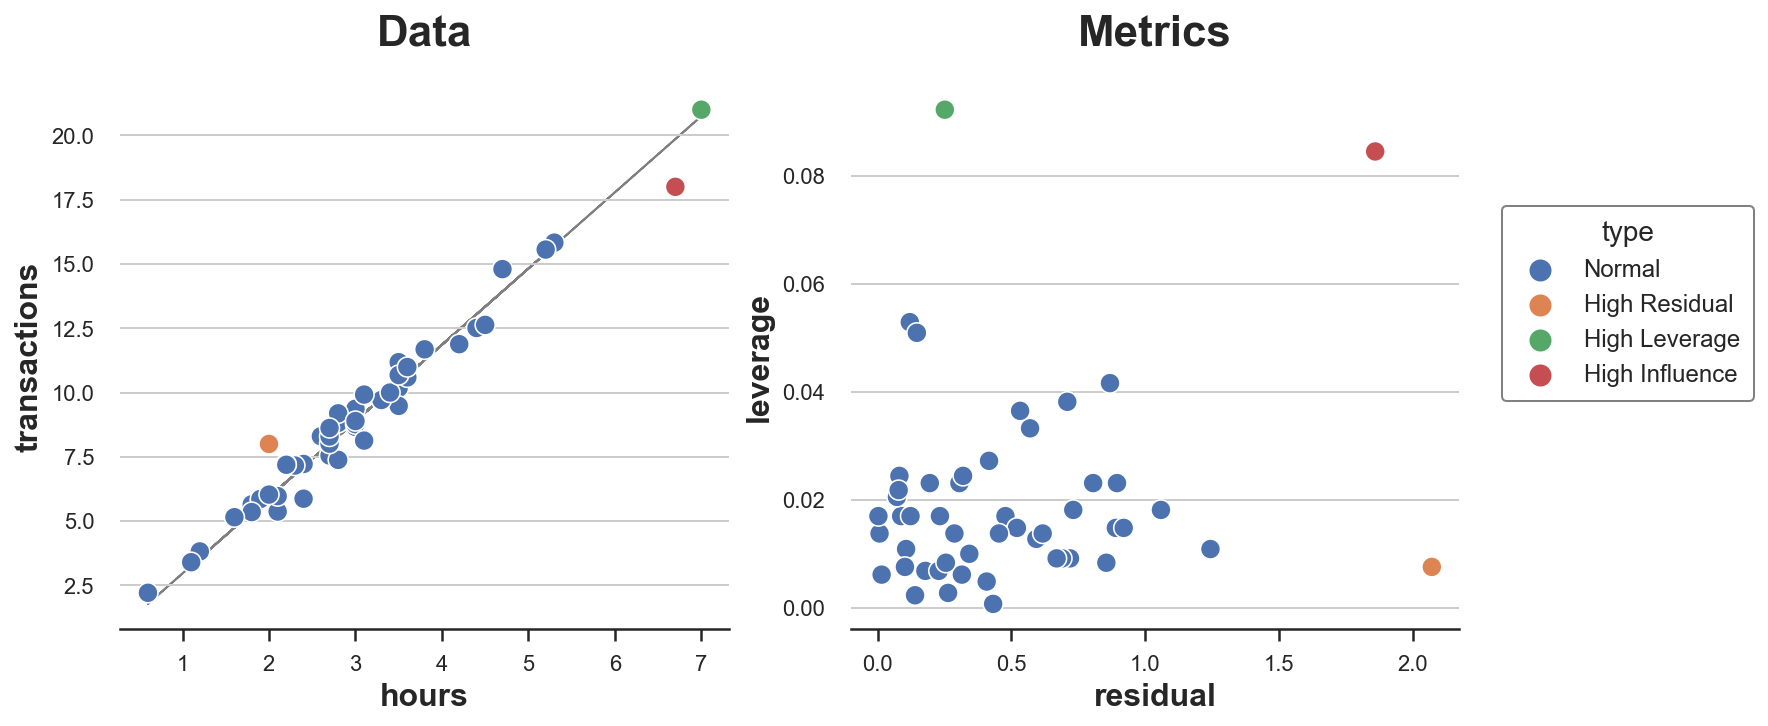

In [50]:
plot_leverage_residuals(df)

As we can see, we have one point with high residual and low leverage, one with high leverage and low residual and only one point with both high leverage and high residual: the only influential point.

From the plot it is also clear why none of the two conditions alone is sufficient for an observation to rive the model. The orange point has high residual but it lies right in the middle of the distribution and therefore cannot tilt the line of best fit. The green point instead has high leverage and lies far from the center of the distribution but its perfectly aligned with the line of fit. Removing it would not change anything. The red dot instead is different from the others in terms of **both characteristics and behavior** and therefore tilts the fit line towards itself.

## Conclusion

In this post, we have seen some different ways in which observations can be "unusual": they can have either unusual characteristics or unusual behavior. In linear regression, when an observation has both it is also influential: it tilts the model towards itself. 

In the example of the article, we concentrated on a univariate linear regression. However, research on influence functions has recently become a hot topic because of the need to make black-box machine learning algorithms understandable. With models with millions of parameters, billions of observations and wild non-linearities, it can be very hard to establish whether a single observation is influential and how.

### References

[1] D. Cook, [Detection of Influential Observation in Linear Regression](https://www.jstor.org/stable/1268249) (1980), *Technometrics*.

[2] D. Cook, S. Weisberg, [Characterizations of an Empirical Influence Function for Detecting Influential Cases in
Regression](https://www.jstor.org/stable/1268187) (1980), *Technometrics*.

[2] P. W. Koh, P. Liang, [Understanding Black-box Predictions via Influence Functions](http://proceedings.mlr.press/v70/koh17a) (2017), *ICML Proceedings*.

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/outliers.ipynb